In [1]:
import lmfit

from readData import read_data, locsFull
import numpy as np; from numpy import sin, cos, tan, e
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

import seaborn as sns; sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
data, specs, locations = read_data();

for loc in locations:
    printmd(f"# {locsFull[loc]}:")
    display(data[loc].head())

# Alabama:

SSM_IS       TAU      SIG40
time                                                   
2007-01-03 11:33:39.374012  0.0164  0.423812 -14.929379
2007-01-03 22:52:30.000000  0.0149  0.423812 -15.069339
2007-01-05 12:32:16.874990  0.0097  0.424047 -14.802873
2007-01-05 23:51:09.373990  0.0172  0.424047 -15.086335
2007-01-08 11:30:14.999020  0.0089  0.424245 -15.191001

# Gevenich:

SSM_IS       TAU     SIG40
time                                                  
2011-08-21 09:09:28.125021   0.307  0.203218 -7.392017
2011-08-22 10:28:48.750014   0.296  0.203290 -7.702011
2011-08-23 10:08:11.249021   0.340  0.203316 -7.187207
2011-08-23 19:55:26.250019   0.326  0.203316 -7.255795
2011-08-24 19:34:48.748987   0.306  0.203313 -7.556310

In [3]:
def yr2008(df):
    return df.loc[pd.datetime(2008,1,1):pd.datetime(2009,1,1)]

In [4]:
params = lmfit.Parameters()
params.add(name = "A", value = -12.5, min = -20, max = -5)
params.add(name = "B", value = 15, min = 0, max = 20)
params.add(name = "ω", value = 0.125, min = 0, max = 0.25)

params

Parameters([('A', <Parameter 'A', value=-12.5, bounds=[-20:-5]>),
            ('B', <Parameter 'B', value=15, bounds=[0:20]>),
            ('ω', <Parameter 'ω', value=0.125, bounds=[0:0.25]>)])

In [5]:
def σ0_soil(A, B, m_v):
    σ0_soil_lin = 10 ** ((A + B * m_v)/10) #m2m-2
    return σ0_soil_lin
    
def water_cloud_model(params, data, θ, residuals = True):
    A = params["A"].value
    B = params["B"].value
    ω = params["ω"].value
    
    SSM = data.SSM_IS
    τ = data.TAU
    
    ref = data.SIG40
    
    γ2 = e ** ((-2 * τ) / cos(θ))
    
    veg = 3 * ω * cos(θ) / 4 * (1 - γ2) 
    soil = σ0_soil(A, B, SSM) * γ2
    
    pred = 10 *np.log10(veg + soil)
    
    res = pred - ref
    
    if residuals:
        return res
    else:
        return pred

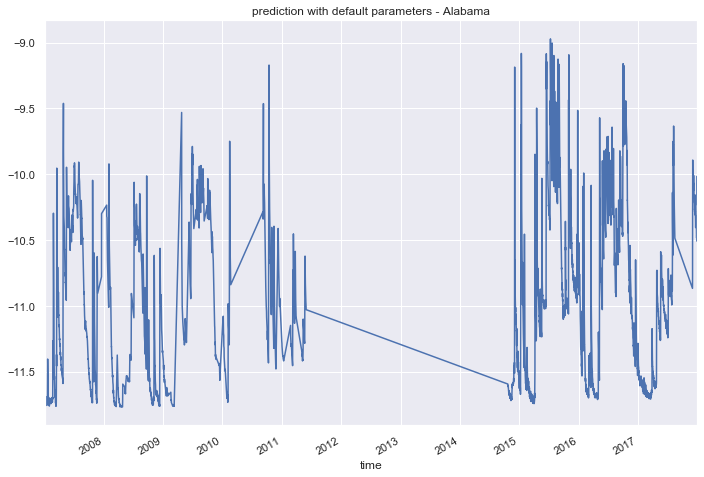

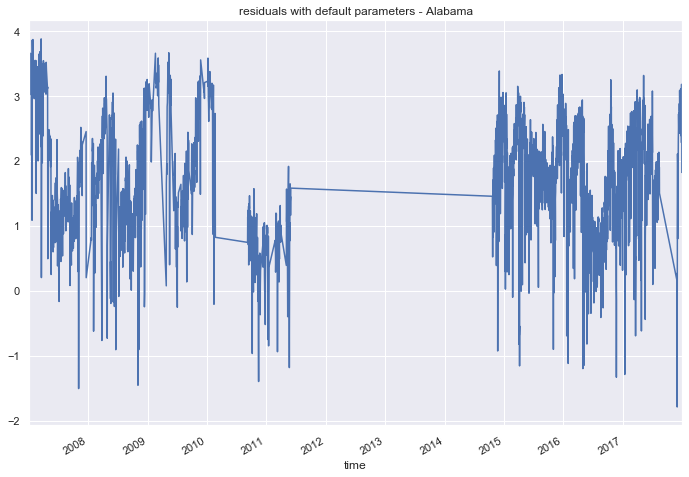

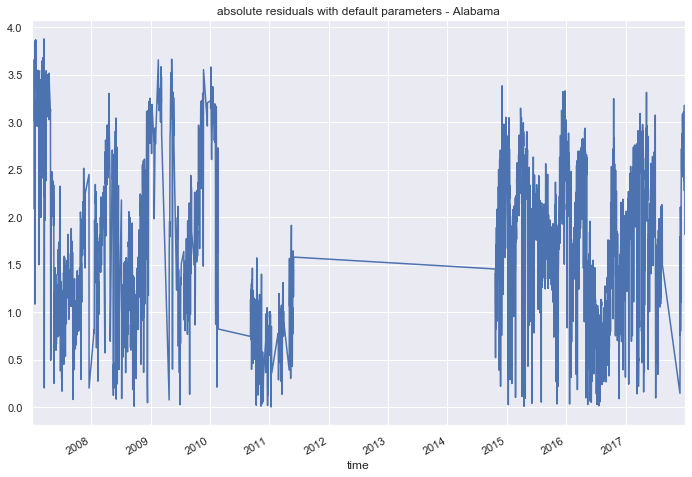

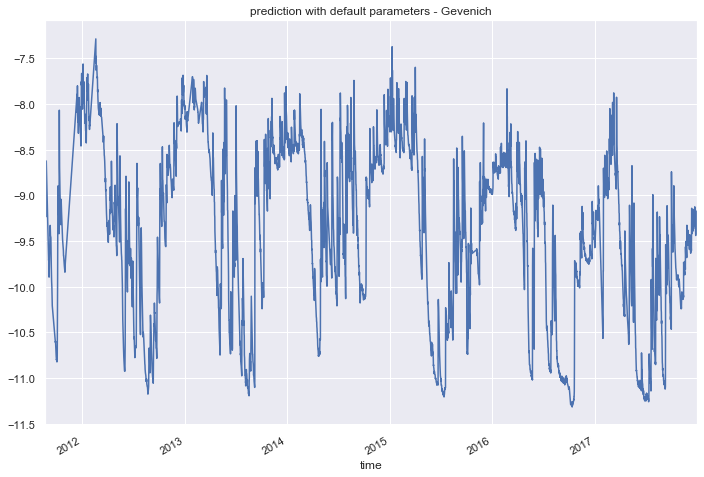

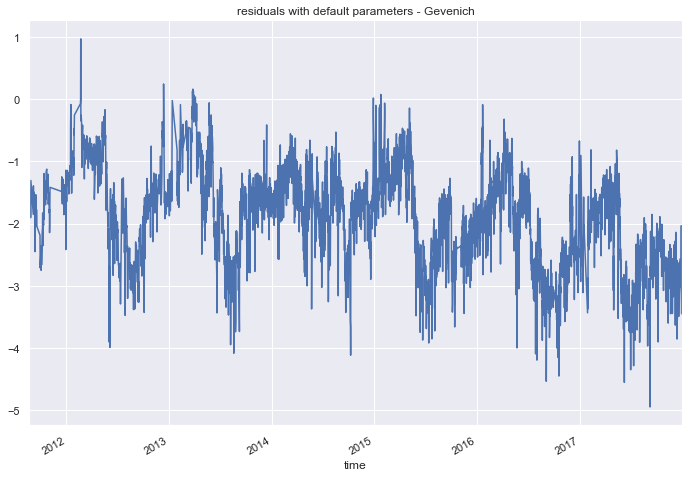

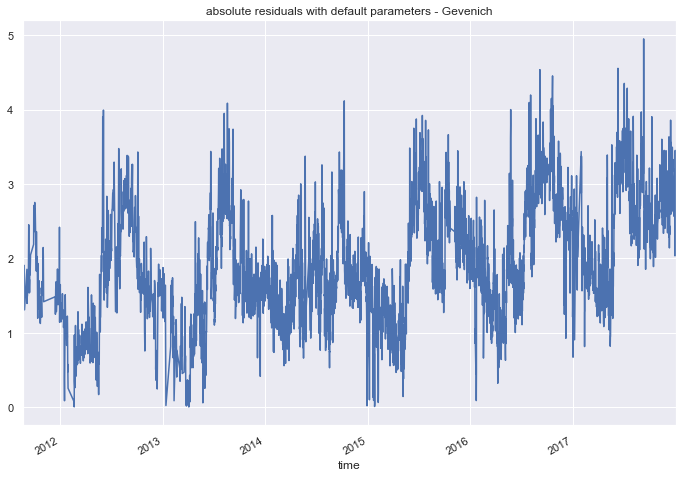

In [6]:
σ0_pred = {}
σ0_res = {}
for loc in locations:
    σ0_pred[loc] = water_cloud_model(params=params, data=data[loc], θ=np.deg2rad(40), residuals=False)#.plot()
    σ0_res[loc] = water_cloud_model(params=params, data=data[loc], θ=np.deg2rad(40), residuals=True)
    σ0_pred[loc].plot()
    plt.title(f"prediction with default parameters - {locsFull[loc]}")
    plt.show()
    σ0_res[loc].plot()
    plt.title(f"residuals with default parameters - {locsFull[loc]}")
    plt.show()
    σ0_res[loc].abs().plot()
    plt.title(f"absolute residuals with default parameters - {locsFull[loc]}")
    plt.show()

In [7]:
result = {}
for loc in locations:
    result[loc] = lmfit.minimize(water_cloud_model, params=params, args=(data[loc], np.deg2rad(40), True), method="leastsq");
    printmd(f"# {locsFull[loc]}:")
    display(result[loc])

# Alabama:

# Gevenich:

In [8]:
result["ala"].params#.pretty_print()

Parameters([('A',
             <Parameter 'A', value=-10.042893745732913 +/- 0.484, bounds=[-20:-5]>),
            ('B',
             <Parameter 'B', value=9.453867089659976 +/- 0.832, bounds=[0:20]>),
            ('ω',
             <Parameter 'ω', value=0.019648416345089417 +/- 0.00992, bounds=[0:0.25]>)])

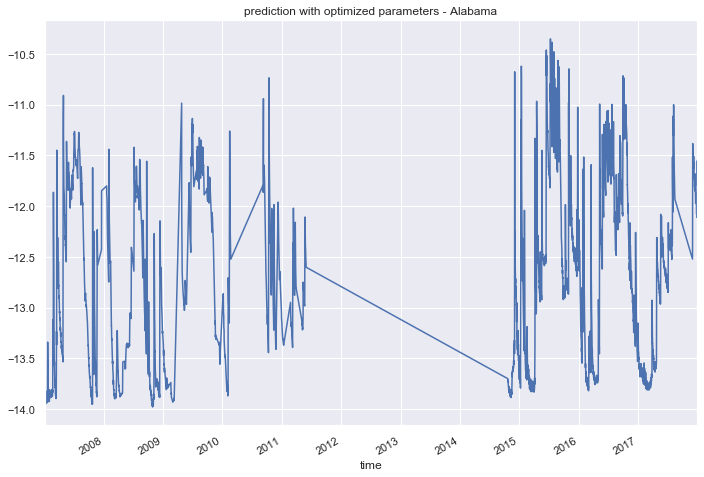

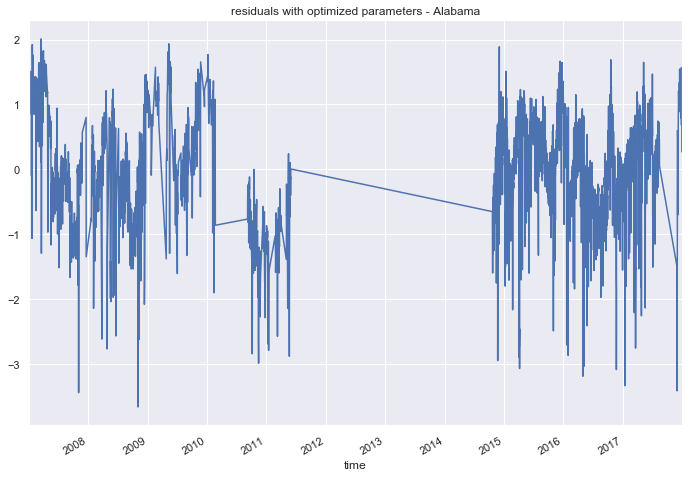

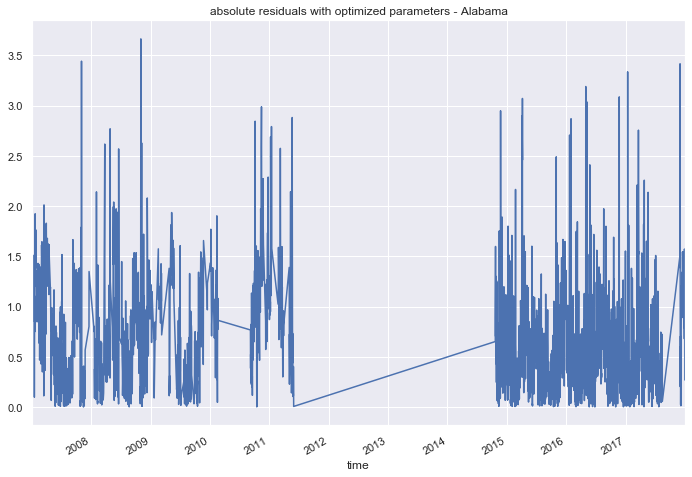

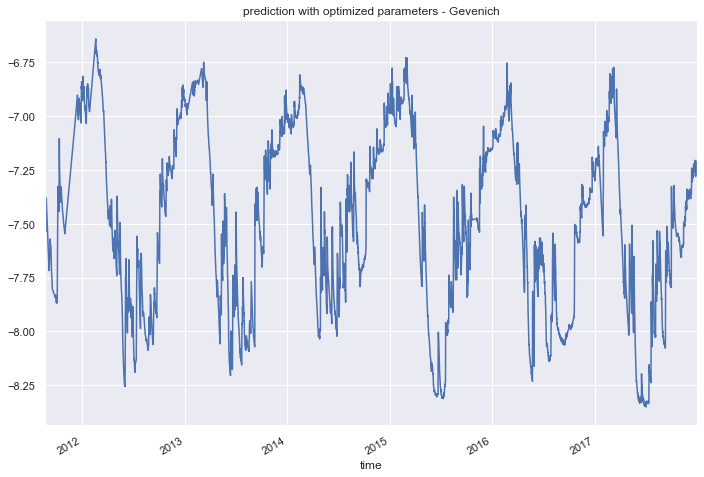

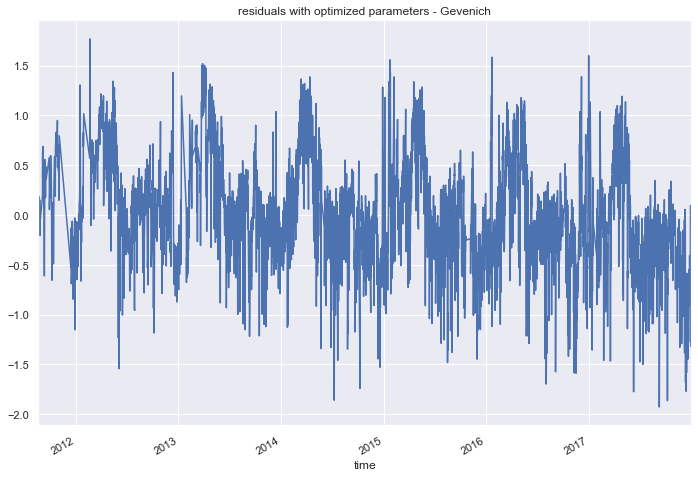

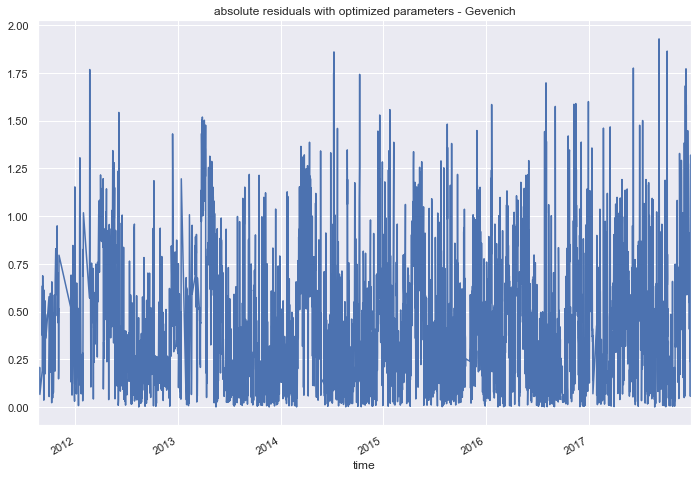

In [9]:
σ0_pred_opt = {}
σ0_res_opt = {}
for loc in locations:
    σ0_pred_opt[loc] = water_cloud_model(params=result[loc].params, data=data[loc], θ=np.deg2rad(40), residuals=False)
    σ0_res_opt[loc] = water_cloud_model(params=result[loc].params, data=data[loc], θ=np.deg2rad(40), residuals=True)
#     σ0_pred_opt[loc].plot()
#     plt.title(f"σ0 predicted {loc}")
#     plt.show()
#     σ0_res_opt[loc].plot()
#     plt.title(f"σ0 residuals {loc}")
#     plt.show()
#     σ0_res_opt[loc].plot()
#     plt.title(f"σ0 residuals {loc}")
#     plt.show()
    
    σ0_pred_opt[loc].plot()
    plt.title(f"prediction with optimized parameters - {locsFull[loc]}")
    plt.show()
    σ0_res_opt[loc].plot()
    plt.title(f"residuals with optimized parameters - {locsFull[loc]}")
    plt.show()
    σ0_res_opt[loc].abs().plot()
    plt.title(f"absolute residuals with optimized parameters - {locsFull[loc]}")
    plt.show()

In [10]:
σ0_res_opt["ala"].abs().median()

0.5437334199425923

In [11]:
σ0_res["ala"].abs().mean()

1.7594198928220077